In [15]:
from getpass import getpass

token = getpass("Token from Forge: ")

In [37]:

from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

In [38]:
from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    LogitsConfig,
    LogitsOutput,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, path) -> LogitsOutput:
    protein = ESMProtein.from_pdb(path)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output



embedding = embed_sequence(model, "../test_data/val/1amr-A-rec-1aia-pmp-lig-tt-docked-0-pocket10.pdb")


embedding


/Users/hanneswidera/Uni/Master/thesis/DiffSBDD/.venv/lib/python3.10/site-packages/esm/utils/misc.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


LogitsOutput(logits=ForwardTrackData(sequence=tensor([[-38.0859, -38.0949, -38.1053,  ..., -38.1104, -38.1425, -38.1369],
        [-37.3101, -37.3237, -37.3614,  ..., -37.3267, -37.3535, -37.3517],
        [-32.1770, -32.1752, -32.2001,  ..., -32.2405, -32.2385, -32.2181],
        ...,
        [-33.5750, -33.5977, -33.6424,  ..., -33.6750, -33.6827, -33.6369],
        [-31.1890, -31.2309, -31.2481,  ..., -31.2445, -31.2893, -31.2470],
        [-30.9164, -30.9297, -30.9619,  ..., -30.9593, -30.9977, -30.9643]]), structure=None, secondary_structure=None, sasa=None, function=None), embeddings=tensor([[[ 6.0654e-04,  1.5335e-03,  5.7373e-03,  ...,  1.5137e-02,
           2.1057e-03, -3.0975e-03],
         [-3.0029e-02,  2.5482e-03,  6.1279e-02,  ...,  3.9795e-02,
           2.1851e-02,  2.4658e-02],
         [-2.6978e-02, -1.8921e-03,  1.4404e-02,  ...,  7.7515e-03,
          -4.3030e-03,  2.4414e-03],
         ...,
         [-3.9795e-02, -4.8161e-05,  5.7983e-03,  ..., -1.7212e-02,
      

In [40]:
embedding.hidden_states.shape

torch.Size([31, 1, 58, 960])

AttributeError: 'Tensor' object has no attribute 'hidden_states'

In [19]:

import torch

# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths

mean_embedding =  torch.mean(embedding.hidden_states, dim=-2).squeeze()


# now we have a list of tensors of [num_layers, hidden_size]
print("embedding shape [num_layers, hidden_size]:", mean_embedding.shape)

embedding shape [num_layers, hidden_size]: torch.Size([31, 960])


In [20]:
last_layer_embedding = mean_embedding[30, :]
last_layer_embedding.shape

torch.Size([960])

In [21]:
# write a function that extracts from val all pdb file paths as strings and returns them as a list
"../test_data/val/1amr-A-rec-1aia-pmp-lig-tt-docked-0-pocket10.pdb"

def get_pdb_file_paths(val_dir: str) -> list[str]:
    import os

    pdb_file_paths = []
    for root, dirs, files in os.walk(val_dir):
        for file in files:
            if file.endswith(".pdb"):
                pdb_file_paths.append(os.path.join(root, file))
    return pdb_file_paths


pdb_file_paths = get_pdb_file_paths("../test_data/val")
pdb_file_paths[:5]

['../test_data/val/3fr5-A-rec-3p6f-fbz-lig-tt-min-0-pocket10.pdb',
 '../test_data/val/3hwf-A-rec-1x71-db1-lig-tt-min-0-pocket10.pdb',
 '../test_data/val/2wzh-A-rec-5fl0-71i-lig-it1-it2-tt-docked-3-pocket10.pdb',
 '../test_data/val/2zjw-A-rec-3mb6-01i-lig-tt-min-0-pocket10.pdb',
 '../test_data/val/4l7d-A-rec-5fzn-fb2-lig-tt-min-0-pocket10.pdb']

## Put it all together

Now that we have all puzzle pieces together create a graph visualizing all embeddings

In [43]:
EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)

def embed_sequence(model: ESM3InferenceClient, path, layer:int=30) -> LogitsOutput:
    protein = ESMProtein.from_pdb(path)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    # we'll summarize the embeddings using their mean across the sequence dimension
    # which allows us to compare embeddings for sequences of different lengths
    print(f"Shape of hidden States {output.hidden_states.shape}")
    mean_embedding =  torch.mean(output.hidden_states, dim=-2).squeeze()
    layer_embedding = mean_embedding[layer, :]
    return layer_embedding

embedding = embed_sequence(model, "../test_data/val/1amr-A-rec-1aia-pmp-lig-tt-docked-0-pocket10.pdb")


Shape of hidden States torch.Size([31, 1, 58, 960])


In [44]:
embeddings = [embed_sequence(model, path) for path in pdb_file_paths]

Shape of hidden States torch.Size([31, 1, 49, 960])
Shape of hidden States torch.Size([31, 1, 32, 960])
Shape of hidden States torch.Size([31, 1, 54, 960])
Shape of hidden States torch.Size([31, 1, 48, 960])
Shape of hidden States torch.Size([31, 1, 41, 960])
Shape of hidden States torch.Size([31, 1, 66, 960])
Shape of hidden States torch.Size([31, 1, 31, 960])
Shape of hidden States torch.Size([31, 1, 44, 960])
Shape of hidden States torch.Size([31, 1, 50, 960])
Shape of hidden States torch.Size([31, 1, 36, 960])
Shape of hidden States torch.Size([31, 1, 50, 960])
Shape of hidden States torch.Size([31, 1, 49, 960])
Shape of hidden States torch.Size([31, 1, 40, 960])
Shape of hidden States torch.Size([31, 1, 48, 960])
Shape of hidden States torch.Size([31, 1, 39, 960])
Shape of hidden States torch.Size([31, 1, 63, 960])
Shape of hidden States torch.Size([31, 1, 37, 960])
Shape of hidden States torch.Size([31, 1, 70, 960])
Shape of hidden States torch.Size([31, 1, 39, 960])
Shape of hid

In [27]:
len(embeddings)

50

In [33]:
# convert to numpy array

numpy_embedding = torch.stack(embeddings).float().numpy()


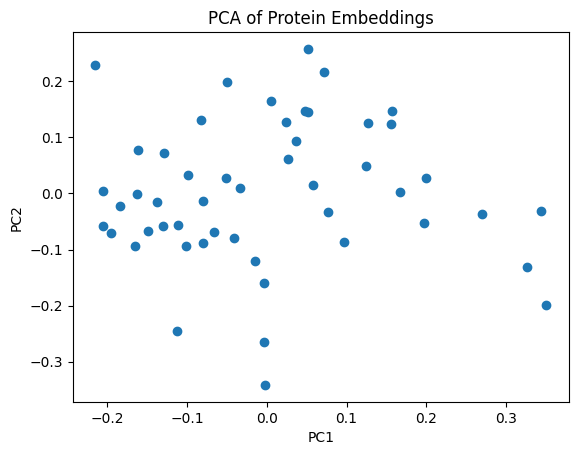

In [34]:
# visualize the embeddings in a 2D plot using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(numpy_embedding)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title("PCA of Protein Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()